# 라이브러리 불러오기

In [85]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas as gpd
from shapely.geometry import Point
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from geopy.distance import geodesic
import matplotlib as mpl
import tqdm
from scipy.spatial.distance import cdist
from scipy.spatial import cKDTree
from sklearn.cluster import KMeans
from statsmodels.tsa.seasonal import seasonal_decompose
import warnings
warnings.filterwarnings("ignore")

# 데이터 불러오기

In [2]:
train_data = pd.read_csv("/data/ephemeral/home/house/data/train.csv")
test_data = pd.read_csv("/data/ephemeral/home/house/data/test.csv")
sample_submission = pd.read_csv("/data/ephemeral/home/house/data/sample_submission.csv")
interest_data = pd.read_csv("/data/ephemeral/home/house/data/interestRate.csv")
park_data = pd.read_csv("/data/ephemeral/home/house/data/parkInfo.csv")
school_data = pd.read_csv("/data/ephemeral/home/house/data/schoolinfo.csv")
subway_data = pd.read_csv("/data/ephemeral/home/house/data/subwayInfo.csv")

In [3]:
train_data.head()

,index,area_m2,contract_year_month,contract_day,contract_type,floor,built_year,latitude,longitude,age,deposit
0,0,84.9981,201906,25,2,9,2019,37.054314,127.045216,0,17000.0
1,1,84.9981,202003,26,2,20,2019,37.054314,127.045216,1,23000.0
2,2,84.9981,202003,28,2,8,2019,37.054314,127.045216,1,23000.0
3,3,59.3400,201907,15,2,1,1986,36.964647,127.055847,33,5000.0
4,4,59.8100,201904,12,2,6,1995,36.972390,127.084514,24,1800.0


In [4]:
test_data.head()

,index,area_m2,contract_year_month,contract_day,contract_type,floor,built_year,latitude,longitude,age
0,0,84.961,202404,12,1,14,2016,36.965423,127.048779,8
1,1,59.900,202404,13,0,4,1997,36.963105,127.040678,27
2,2,39.270,202404,29,0,5,1990,36.957089,127.047449,34
3,3,39.270,202405,3,0,1,1990,36.957089,127.047449,34
4,4,46.980,202406,2,0,4,1990,36.957089,127.047449,34


In [5]:
sample_submission.head()

,index,deposit
0,0,0
1,1,0
2,2,0
3,3,0
4,4,0


In [6]:
interest_data.head()

,year_month,interest_rate
0,202405,3.56
1,202404,3.54
2,202403,3.59
3,202402,3.62
4,202401,3.66


In [7]:
park_data.head()

,latitude,longitude,area
0,37.509628,127.628406,856.0
1,37.508443,127.627414,847.0
2,37.493844,127.509326,1276.0
3,37.496021,127.408216,3300.0
4,37.496164,127.412326,394.0


In [8]:
school_data.head()

,schoolLevel,latitude,longitude
0,elementary,37.703889,127.540156
1,elementary,37.676874,127.600664
2,elementary,36.987340,129.399471
3,elementary,34.808753,126.456974
4,elementary,35.854580,127.003365


In [9]:
subway_data.head()

,latitude,longitude
0,37.759380,127.042292
1,37.541021,126.971300
2,37.529849,126.964561
3,37.514219,126.942454
4,37.513342,126.926382


In [10]:
train_data.dtypes

index                    int64
area_m2                float64
contract_year_month      int64
contract_day             int64
contract_type            int64
floor                    int64
built_year               int64
latitude               float64
longitude              float64
age                      int64
deposit                float64
dtype: object

# 결측치 확인

In [11]:
print("Train 데이터 결측치 확인:\n", train_data.isnull().sum())
print("Test 데이터 결측치 확인:\n", test_data.isnull().sum())
print("Subway 데이터 결측치 확인:\n", subway_data.isnull().sum())
print("Interest Rate 데이터 결측치 확인:\n", interest_data.isnull().sum())
print("School 데이터 결측치 확인:\n", school_data.isnull().sum())
print("Park 데이터 결측치 확인:\n", park_data.isnull().sum())

Train 데이터 결측치 확인:
 index                  0
area_m2                0
contract_year_month    0
contract_day           0
contract_type          0
floor                  0
built_year             0
latitude               0
longitude              0
age                    0
deposit                0
dtype: int64
Test 데이터 결측치 확인:
 index                  0
area_m2                0
contract_year_month    0
contract_day           0
contract_type          0
floor                  0
built_year             0
latitude               0
longitude              0
age                    0
dtype: int64
Subway 데이터 결측치 확인:
 latitude     0
longitude    0
dtype: int64
Interest Rate 데이터 결측치 확인:
 year_month       0
interest_rate    0
dtype: int64
School 데이터 결측치 확인:
 schoolLevel    0
latitude       0
longitude      0
dtype: int64
Park 데이터 결측치 확인:
 latitude     0
longitude    0
area         0
dtype: int64


# 데이터 병합

### interestRate.csv와 병합

In [12]:
# train_data와 interest_data 병합
train_data['contract_year_month'] = train_data['contract_year_month'].astype(str)
interest_data['year_month'] = interest_data['year_month'].astype(str)

# left join을 통해 금리 데이터를 병합
train_data = pd.merge(train_data, interest_data, how='left', left_on='contract_year_month', right_on='year_month')

# 중복된 열 제거
train_data.drop(columns=['year_month'], inplace=True)

### subwayinfo.csv와 병합

In [13]:
def find_closest_distance_kdtree(train_data, loc_df):
    train_coords = train_data[['latitude', 'longitude']].values
    park_coords = loc_df[['latitude', 'longitude']].values
    tree = cKDTree(park_coords)
    distances, _ = tree.query(train_coords)
    return distances

In [14]:
train_data['closest_subway_distance'] = find_closest_distance_kdtree(train_data, subway_data)

In [15]:
train_data['closest_subway_distance']

0          0.007910
1          0.007910
2          0.007910
3          0.039234
4          0.018347
             ...   
1801223    0.016569
1801224    0.016569
1801225    0.016569
1801226    0.016569
1801227    0.016569
Name: closest_subway_distance, Length: 1801228, dtype: float64

### schoolinfo.csv와 병합

In [16]:
train_data['closest_school_distance'] = find_closest_distance_kdtree(train_data, school_data)

### parkinfo.csv와 병합

In [17]:
train_data['closest_park_distance'] = find_closest_distance_kdtree(train_data, park_data)

In [18]:
print(train_data[['closest_subway_distance', 'closest_school_distance', 'closest_park_distance']].head())

   closest_subway_distance  closest_school_distance  closest_park_distance
0                 0.007910                 0.001558               0.004779
1                 0.007910                 0.001558               0.004779
2                 0.007910                 0.001558               0.004779
3                 0.039234                 0.002046               0.001706
4                 0.018347                 0.015370               0.004277


# 데이터 분포 확인

### 지하철 위치 시각화

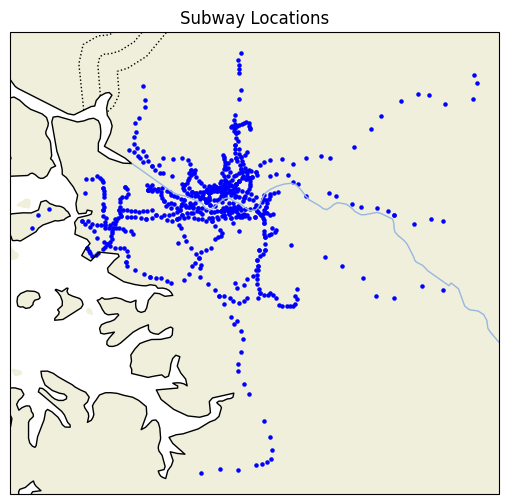

In [19]:
# 지하철 위치 시각화
plt.figure(figsize=(10, 6))
ax = plt.axes(projection=ccrs.PlateCarree())

# 지도에 육지와 강을 추가
ax.add_feature(cfeature.LAND)
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.BORDERS, linestyle=':')
ax.add_feature(cfeature.RIVERS)

# 지하철 위치 플로팅
gdf_subway = gpd.GeoDataFrame(subway_data, geometry=gpd.points_from_xy(subway_data.longitude, subway_data.latitude))
gdf_subway.plot(ax=ax, color='blue', markersize=5)

plt.title('Subway Locations')
plt.show()

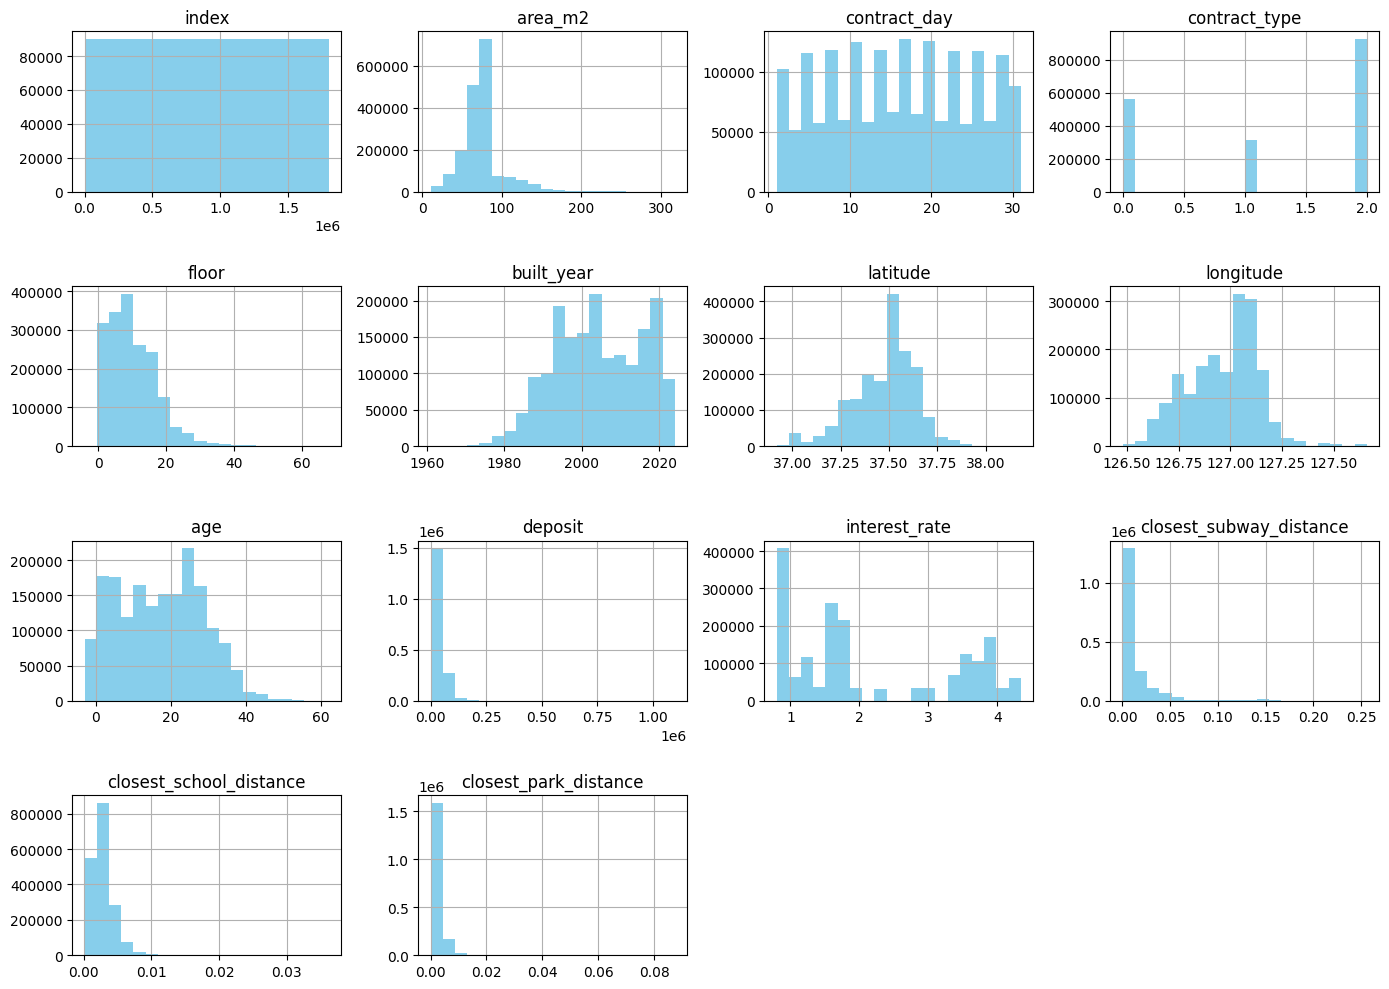

In [20]:
# 히스토그램
train_data.hist(bins=20, figsize=(14, 10), color='skyblue')
plt.tight_layout()
plt.show()

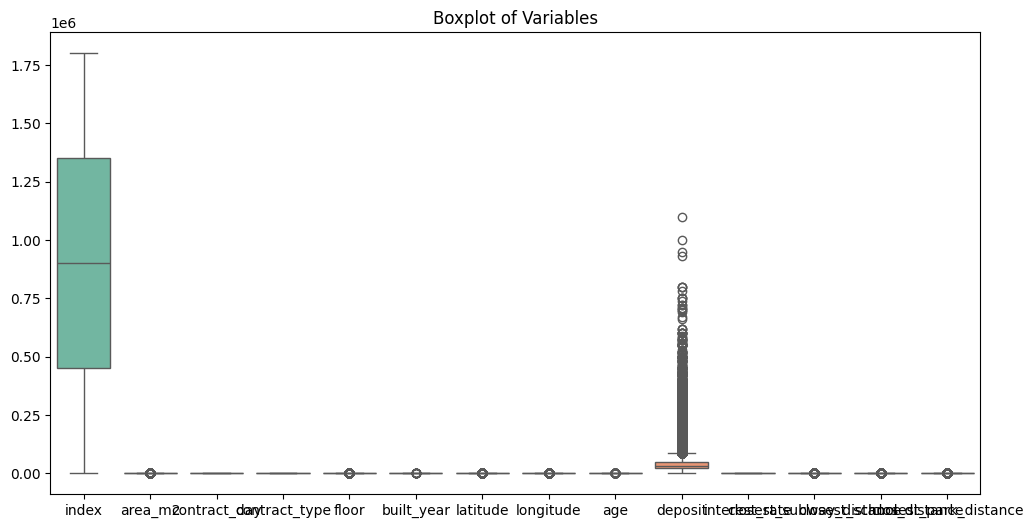

In [21]:
# 박스플롯 (Outlier 확인)
plt.figure(figsize=(12, 6))
sns.boxplot(data=train_data, palette='Set2')
plt.title('Boxplot of Variables')
plt.show()

# 상관관계 분석

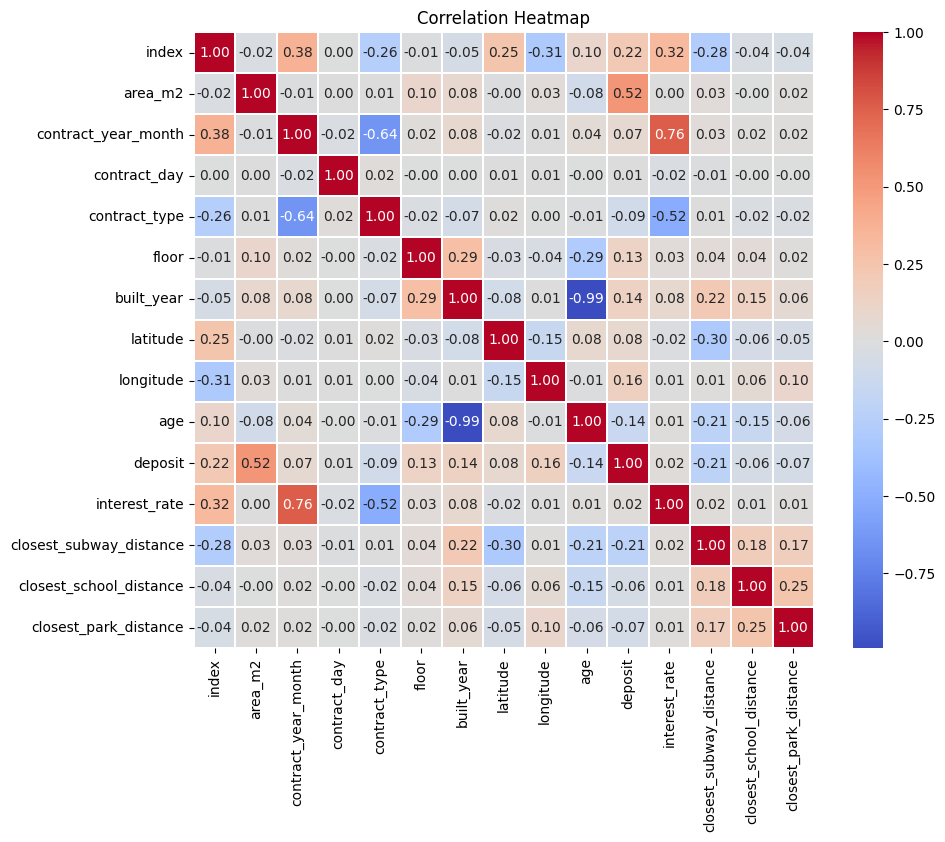

In [22]:
# 상관관계 히트맵
plt.figure(figsize=(10, 8))
sns.heatmap(train_data.corr(), annot=True, fmt=".2f", cmap='coolwarm', linewidths=0.2)
plt.title('Correlation Heatmap')
plt.show()

### 전세가와 금리 분포 확인 및 비교

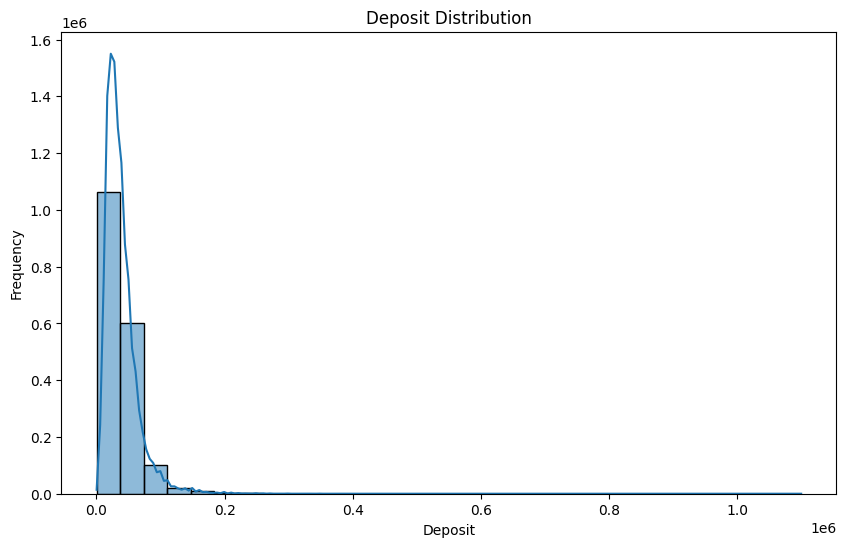

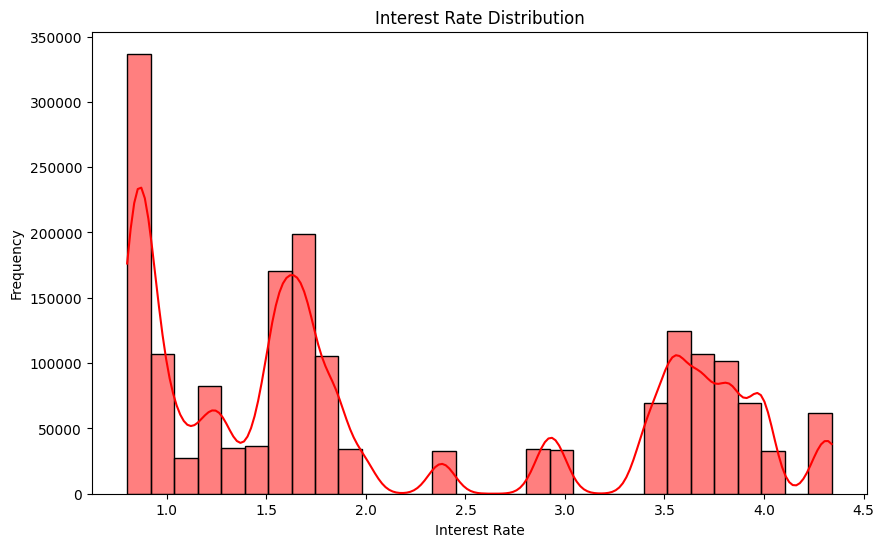

In [23]:
# 전세가 분포 시각화
plt.figure(figsize=(10, 6))
sns.histplot(train_data['deposit'], kde=True, bins=30)
plt.title('Deposit Distribution')
plt.xlabel('Deposit')
plt.ylabel('Frequency')
plt.show()

# 금리 분포 시각화
plt.figure(figsize=(10, 6))
sns.histplot(train_data['interest_rate'], kde=True, color='red', bins=30)
plt.title('Interest Rate Distribution')
plt.xlabel('Interest Rate')
plt.ylabel('Frequency')
plt.show()

### 계약 유형 별 전세가 비교

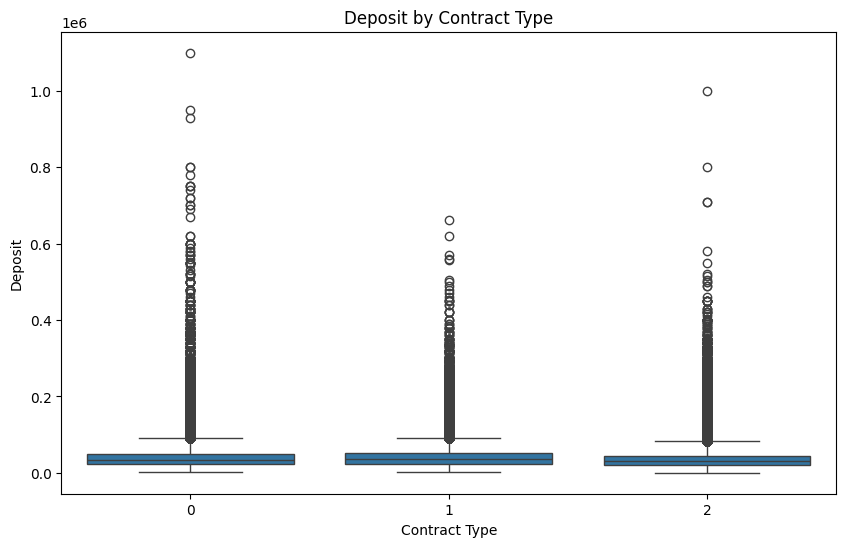

In [24]:
# 계약 유형별 전세가 상자 그림
plt.figure(figsize=(10, 6))
sns.boxplot(x='contract_type', y='deposit', data=train_data)
plt.title('Deposit by Contract Type')
plt.xlabel('Contract Type')
plt.ylabel('Deposit')
plt.show()

### 건축 연도 별 전세가 비교

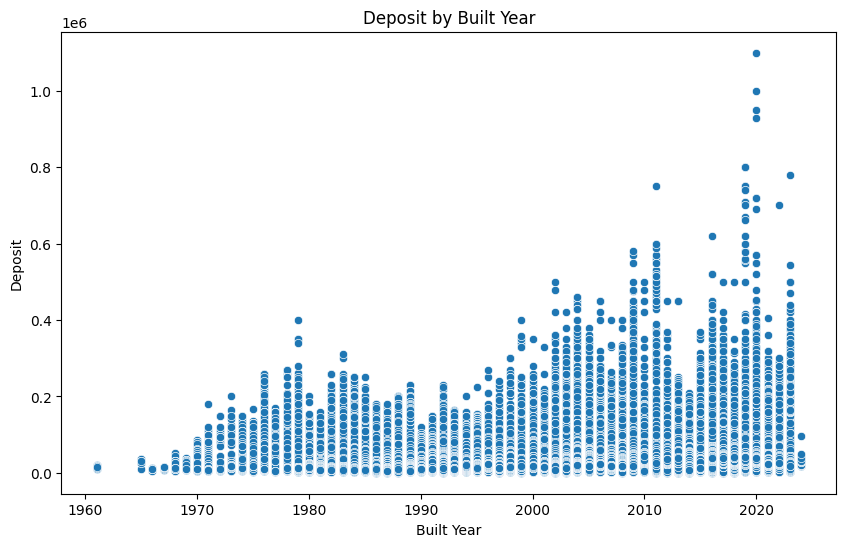

In [25]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x='built_year', y='deposit', data=train_data)
plt.title('Deposit by Built Year')
plt.xlabel('Built Year')
plt.ylabel('Deposit')
plt.show()

### 층수별 전세가 비교

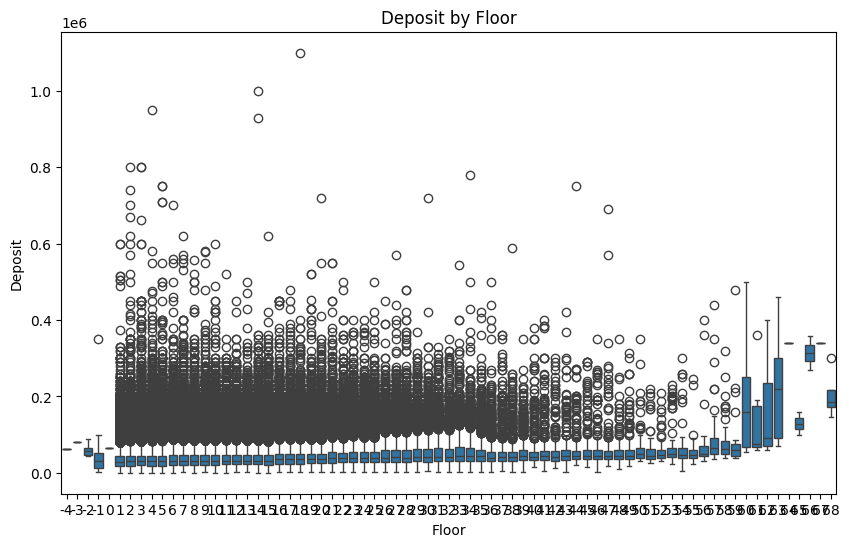

In [26]:
plt.figure(figsize=(10, 6))
sns.boxplot(x='floor', y='deposit', data=train_data)
plt.title('Deposit by Floor')
plt.xlabel('Floor')
plt.ylabel('Deposit')
plt.show()


### 면적과 전세가 비교

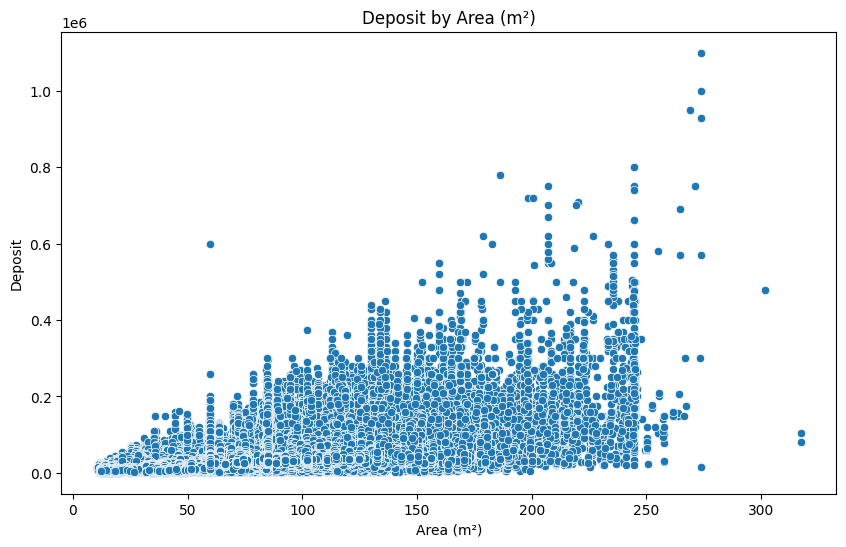

In [27]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x='area_m2', y='deposit', data=train_data)
plt.title('Deposit by Area (m²)')
plt.xlabel('Area (m²)')
plt.ylabel('Deposit')
plt.show()


### latitude와 longitude를 활용한 전세가 지리적 분포 분석

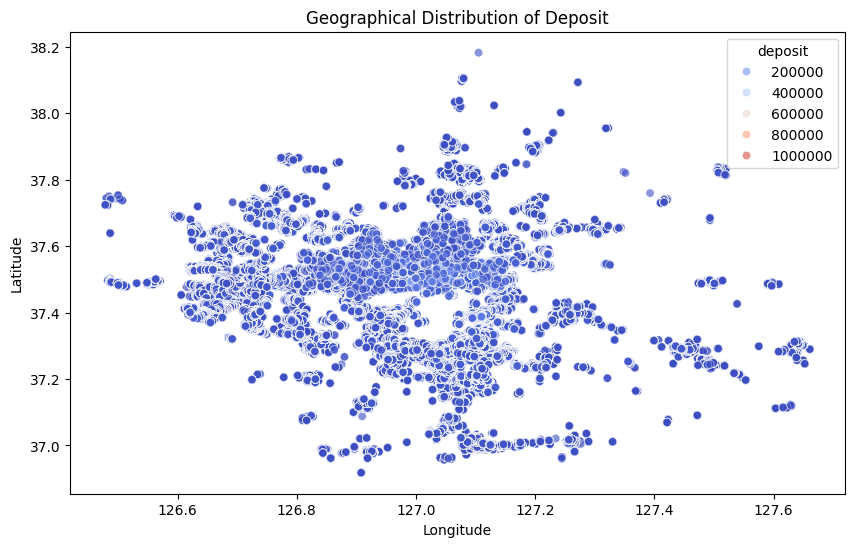

In [28]:
# 위도와 경도를 기반으로 한 전세가 분포 시각화
plt.figure(figsize=(10, 6))
sns.scatterplot(x='longitude', y='latitude', hue='deposit', data=train_data, palette='coolwarm', alpha=0.6)
plt.title('Geographical Distribution of Deposit')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()

/tmp/ipykernel_130860/2866322914.py:6: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap('coolwarm')


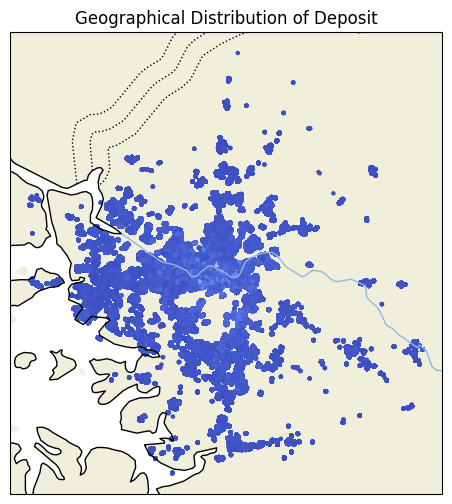

In [29]:
# 전세가 데이터를 GeoDataFrame으로 변환
gdf_deposit = gpd.GeoDataFrame(train_data, geometry=gpd.points_from_xy(train_data.longitude, train_data.latitude))

# 전세가 값에 따라 색상을 지정하기 위한 컬러맵 설정
norm = plt.Normalize(vmin=gdf_deposit['deposit'].min(), vmax=gdf_deposit['deposit'].max())
cmap = plt.cm.get_cmap('coolwarm')

# 지도 생성
plt.figure(figsize=(10, 6))
ax = plt.axes(projection=ccrs.PlateCarree())

# 지도에 육지, 해안선, 국경, 강 추가
ax.add_feature(cfeature.LAND)
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.BORDERS, linestyle=':')
ax.add_feature(cfeature.RIVERS)

# 전세가에 따라 위치에 플로팅
gdf_deposit.plot(ax=ax, color=gdf_deposit['deposit'].apply(lambda x: cmap(norm(x))), markersize=5)

plt.title('Geographical Distribution of Deposit')
plt.show()

### 근접성 변수와 전세가의 관계

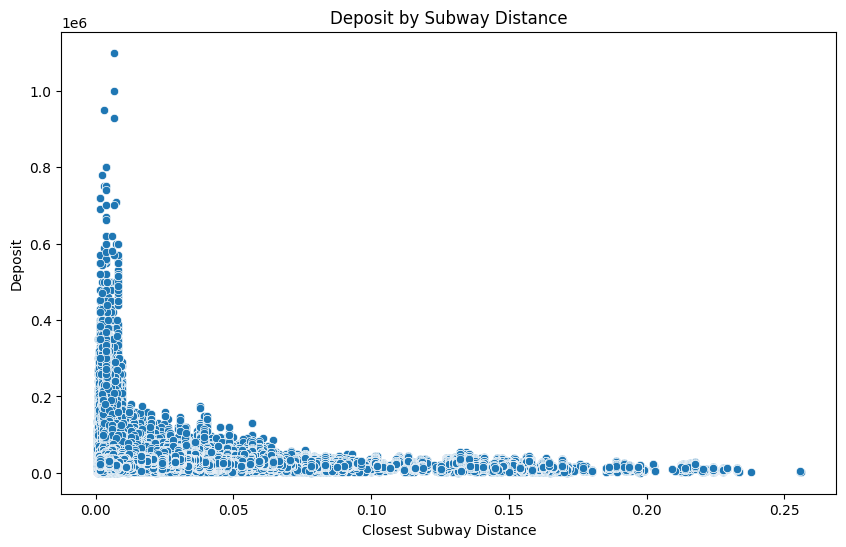

In [30]:
# 지하철과의 거리 vs 전세가
plt.figure(figsize=(10, 6))
sns.scatterplot(x='closest_subway_distance', y='deposit', data=train_data)
plt.title('Deposit by Subway Distance')
plt.xlabel('Closest Subway Distance')
plt.ylabel('Deposit')
plt.show()

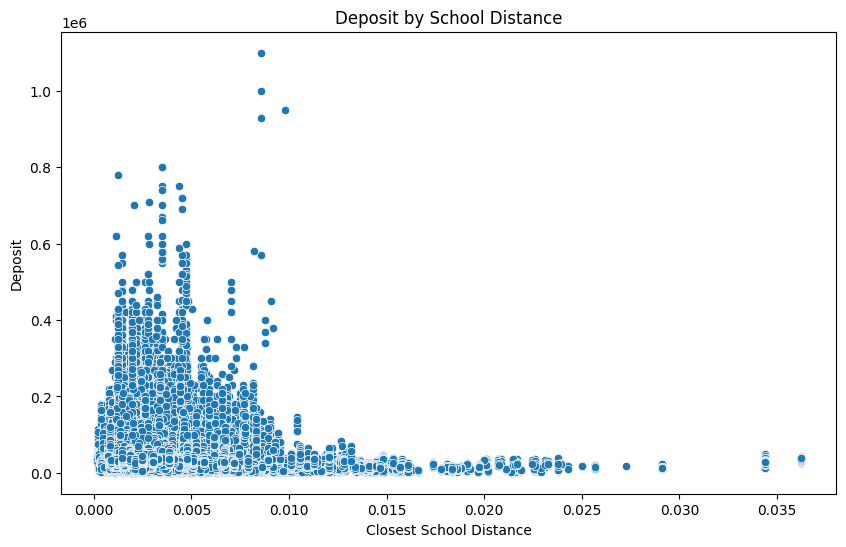

In [31]:
# 학교와의 거리 vs 전세가
plt.figure(figsize=(10, 6))
sns.scatterplot(x='closest_school_distance', y='deposit', data=train_data)
plt.title('Deposit by School Distance')
plt.xlabel('Closest School Distance')
plt.ylabel('Deposit')
plt.show()

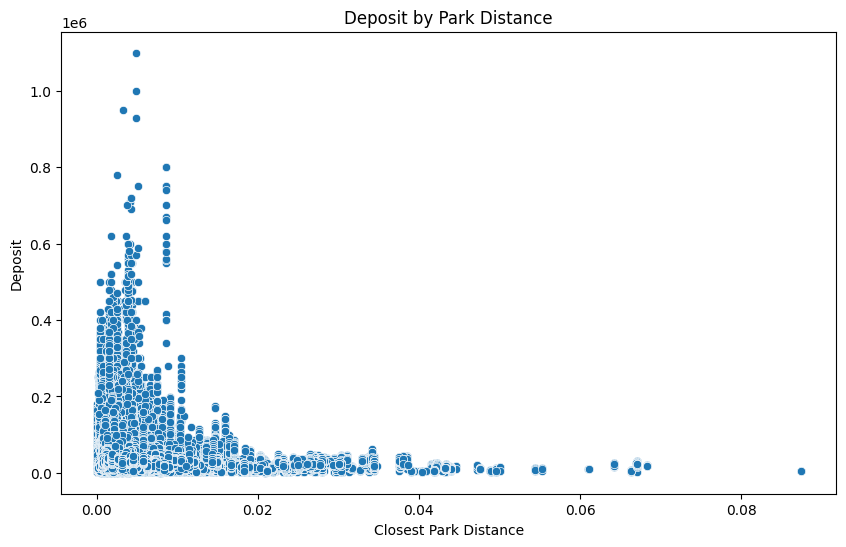

In [32]:
# 공원과의 거리 vs 전세가
plt.figure(figsize=(10, 6))
sns.scatterplot(x='closest_park_distance', y='deposit', data=train_data)
plt.title('Deposit by Park Distance')
plt.xlabel('Closest Park Distance')
plt.ylabel('Deposit')
plt.show()

### 거리와 전세가의 관계
지하철, 학교, 공원 거리: 각 거리와 전세가 간의 관계를 시각화한 결과
- 거리가 가까울수록 전세가가 높아지는 경향 관찰
- 즉, 접근성이 좋은 위치일수록 더 높은 전세가를 형성할 가능성 존재

# 카테고리 변수 분석

/tmp/ipykernel_130860/4241461349.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='contract_type', data=train_data, palette='muted')


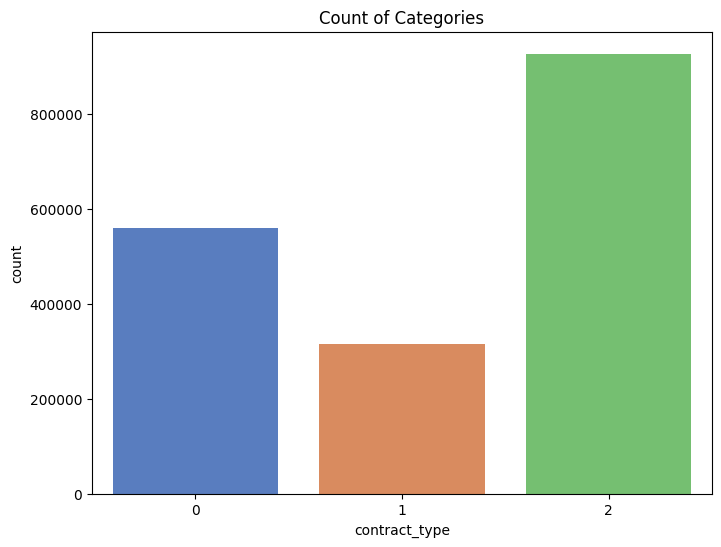

In [33]:
# 범주형 변수의 빈도수 확인 (가상 변수 'category'로 예시)
plt.figure(figsize=(8, 6))
sns.countplot(x='contract_type', data=train_data, palette='muted')
plt.title('Count of Categories')
plt.show()

### 계약 연월별 전세가 및 금리 추세

In [34]:
train_data['contract_year_month'] = pd.to_datetime(train_data['contract_year_month'], format='%Y%m')
monthly_avg = train_data.groupby('contract_year_month').agg({'deposit': 'mean', 'interest_rate': 'mean'}).reset_index()

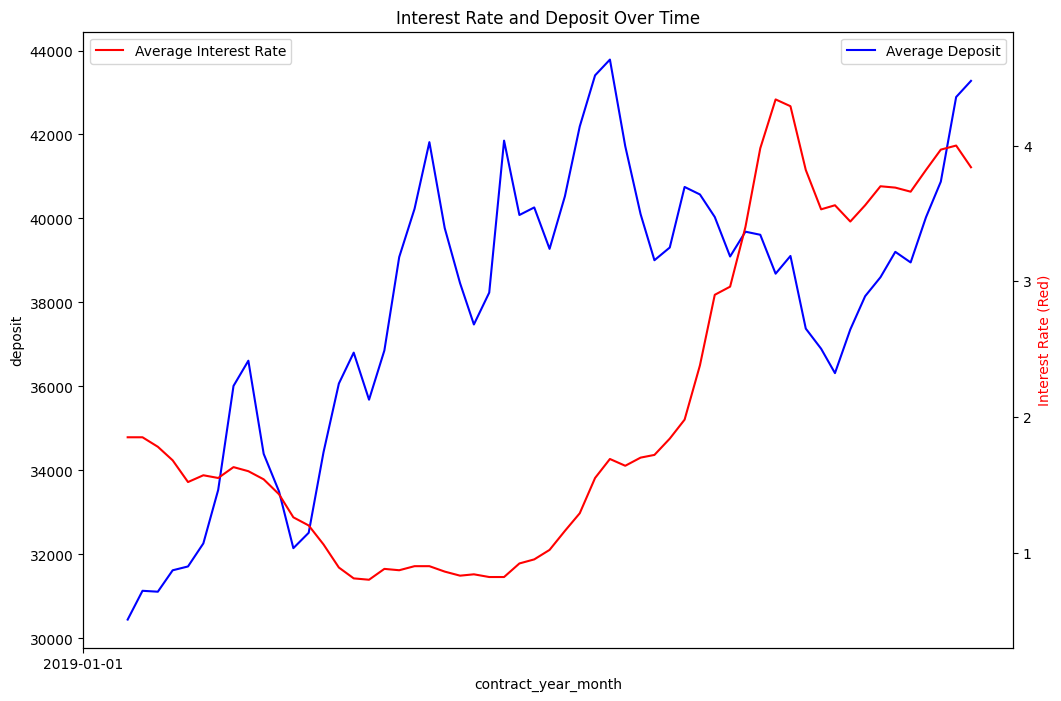

In [35]:
# 계약 연월별 전세가 및 금리 추세 시각화 개선
plt.figure(figsize=(12, 8))

# 첫 번째 y축: 전세가 (Deposit) 시각화
sns.lineplot(x='contract_year_month', y='deposit', data=monthly_avg, label='Average Deposit', color='blue')

# 두 번째 y축: 금리 (Interest Rate) 시각화
ax2 = plt.twinx()  # 두 번째 y축을 추가
sns.lineplot(x='contract_year_month', y='interest_rate', data=monthly_avg, label='Average Interest Rate', color='red', ax=ax2)

# 그래프 제목과 축 설정
plt.title('Interest Rate and Deposit Over Time')
plt.xlabel('Contract Year-Month')
plt.ylabel('Deposit (Blue)', color='blue')
ax2.set_ylabel('Interest Rate (Red)', color='red')

# x축 라벨을 일정 간격으로 보기 쉽게 회전
plt.xticks(rotation=45)

# X축 간격 설정: 라벨이 겹치지 않도록 일정 간격만 표시
plt.xticks(ticks=plt.gca().get_xticks()[::6])  # 라벨을 6개마다 한 번씩 표시

# Y축 범위 설정: 금리의 변화를 더 잘 보이도록 조정
ax2.set_ylim(monthly_avg['interest_rate'].min() - 0.5,monthly_avg['interest_rate'].max() + 0.5)

plt.legend(loc="upper left")
plt.show()

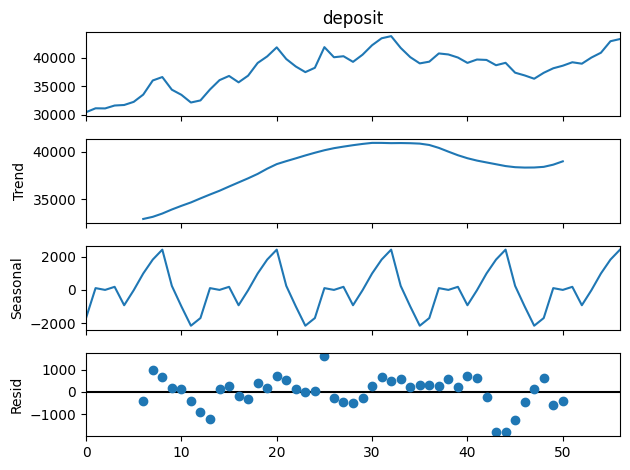

In [36]:
# 시계열 분해 (계절성 및 트렌드 파악)
result = seasonal_decompose(monthly_avg['deposit'], model='additive', period=12)
result.plot()
plt.show()

- 전세가의 전반적인 상승 추세를 확인

## 상호작용 효과 탐색

/opt/conda/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


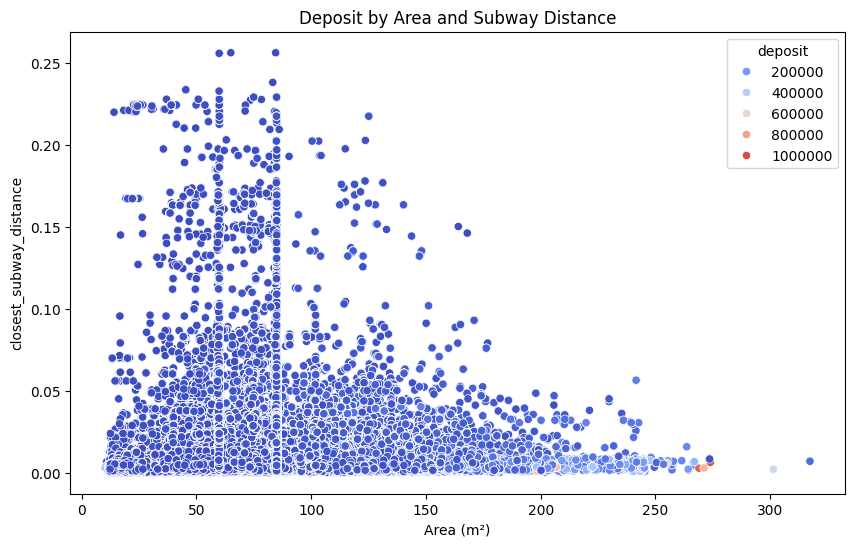

In [37]:
# 거리와 면적의 상호작용이 전세가에 미치는 영향
plt.figure(figsize=(10, 6))
sns.scatterplot(x='area_m2', y='closest_subway_distance', hue='deposit', data=train_data, palette='coolwarm')
plt.title('Deposit by Area and Subway Distance')
plt.xlabel('Area (m²)')
plt.ylabel('closest_subway_distance')
plt.show()

In [38]:
min(train_data['closest_subway_distance'])

0.000290851938274433

- 면적이 클수록 전세가가 증가하는 경향을 확인
- 지하철과의 거리가 가까울수록 deposit 증가하는 경향을 확인

### 지역별 분석

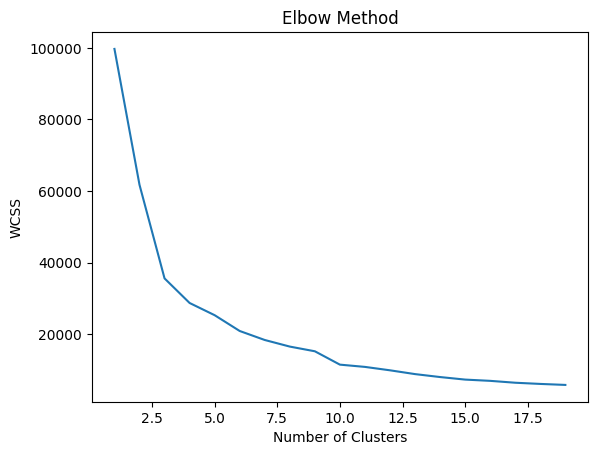

In [39]:
coords = train_data[['latitude', 'longitude']]
wcss = []
for i in range(1, 20):
    kmeans = KMeans(n_clusters=i, random_state=42)
    kmeans.fit(coords)
    wcss.append(kmeans.inertia_)

plt.plot(range(1, 20), wcss)
plt.title('Elbow Method')
plt.xlabel('Number of Clusters')
plt.ylabel('WCSS')
plt.show()

### 엘보우 방법(Elbow Method)
- 클러스터 수에 따른 WCSS(Within-Cluster Sum of Squares)를 계산하고, 그래프에서 급격한 변화가 있는 지점을 찾음
- 이 지점이 적절한 클러스터 수
- 여기서는 3

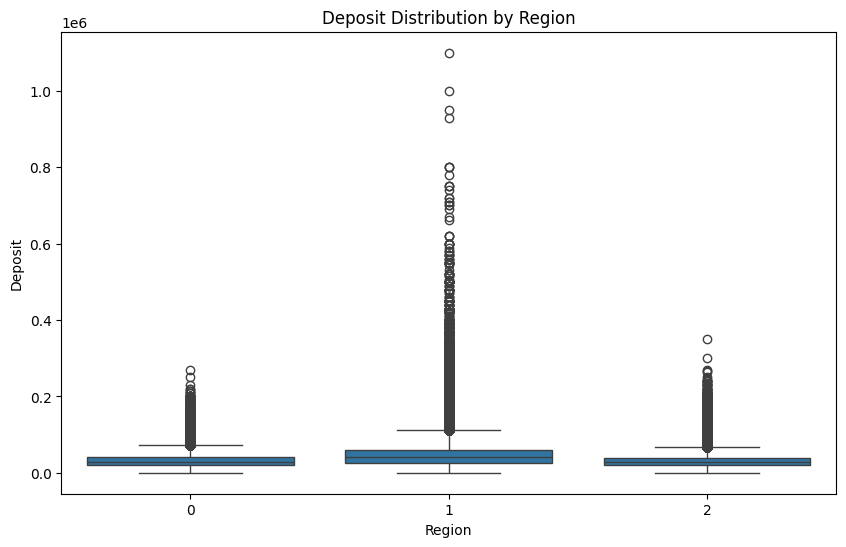

In [40]:
# 위도와 경도를 기반으로 KMeans 클러스터링
coords = train_data[['latitude', 'longitude']]
kmeans = KMeans(n_clusters=3, random_state=42).fit(coords)
train_data['region'] = kmeans.labels_

# 지역별 전세가 분포 시각화
plt.figure(figsize=(10, 6))
sns.boxplot(x='region', y='deposit', data=train_data)
plt.title('Deposit Distribution by Region')
plt.xlabel('Region')
plt.ylabel('Deposit')
plt.show()

In [41]:
train_data['region']

0          0
1          0
2          0
3          0
4          0
          ..
1801223    2
1801224    2
1801225    2
1801226    2
1801227    2
Name: region, Length: 1801228, dtype: int32

# Feature Engineering

### 모델링에 필요한 라이브러리 임포트

In [51]:
from sklearn.model_selection import train_test_split, KFold, cross_val_score, GridSearchCV
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, VotingRegressor
from sklearn.metrics import mean_absolute_error
import xgboost as xgb
import lightgbm as lgb
from sklearn.preprocessing import StandardScaler
import optuna

/opt/conda/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [52]:
# 날짜 관련 피처 생성
train_data['contract_year_month'] = pd.to_datetime(train_data['contract_year_month'], format='%Y%m')
train_data['contract_year'] = train_data['contract_year_month'].dt.year
train_data['contract_month'] = train_data['contract_year_month'].dt.month
train_data['contract_season'] = train_data['contract_year_month'].dt.quarter

In [54]:
# 거리 로그 변환
train_data['log_subway_distance'] = np.log1p(train_data['closest_subway_distance'])
train_data['log_school_distance'] = np.log1p(train_data['closest_school_distance'])
train_data['log_park_distance'] = np.log1p(train_data['closest_park_distance'])

In [55]:
# 피처 및 타겟 설정
X = train_data[['area_m2', 'floor', 'built_year', 'region', 'latitude', 'longitude', 'log_subway_distance', 'log_school_distance', 'log_park_distance', 'contract_year', 'contract_month', 'contract_season']]
y = train_data['deposit']

In [56]:
# 데이터 분리
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Modeling

In [89]:
# 모델 정의
models = {
    'LinearRegression': LinearRegression(),
    'Ridge': Ridge(),
    'Lasso': Lasso(),
    #'RandomForest': RandomForestRegressor(n_estimators=50, max_depth=10, n_jobs=-1, random_state=42),
    #'GradientBoosting': GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42),
    'XGBoost': xgb.XGBRegressor(tree_method='gpu_hist', gpu_id=0, random_state=42),
    'LightGBM': lgb.LGBMRegressor(random_state=42)
}

### 기본 모델 적용 및 평가(K-Fold CV)

In [90]:
# KFold 설정
kf = KFold(n_splits=5, shuffle=True, random_state=42)

In [91]:
# 모델 학습 및 평가
for name, model in models.items():
    scores = cross_val_score(model, X_train, y_train, cv=kf, scoring='neg_mean_absolute_error')
    print(f"{name}: Mean MAE = {-scores.mean():.4f}, Std = {scores.std():.4f}")

LinearRegression: Mean MAE = 13355.1070, Std = 18.6425
Ridge: Mean MAE = 13353.1490, Std = 18.2633
Lasso: Mean MAE = 13355.3418, Std = 17.5372
XGBoost: Mean MAE = 5794.4353, Std = 24.5487
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.011000 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1679
[LightGBM] [Info] Number of data points in the train set: 1152785, number of used features: 12
[LightGBM] [Info] Start training from score 38188.653739
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.011315 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1678
[LightGBM] [Info] Number of data points in the train set: 1152785, number of used features: 12
[LightGBM] [Info] Start training from score 3

### 하이퍼파라미터 튜닝(Optuna)

In [94]:
# def rf_objective(trial):
#     n_estimators = trial.suggest_int('n_estimators', 50, 300)
#     max_depth = trial.suggest_int('max_depth', 3, 20)
#     min_samples_split = trial.suggest_int('min_samples_split', 2, 10)
#     min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 4)
    
#     model = RandomForestRegressor(
#         n_estimators=n_estimators,
#         max_depth=max_depth,
#         min_samples_split=min_samples_split,
#         min_samples_leaf=min_samples_leaf,
#         random_state=42
#     )
    
#     score = cross_val_score(model, X_train, y_train, cv=kf, scoring='neg_mean_absolute_error')
#     return -score.mean()

# rf_study = optuna.create_study(direction='minimize')
# rf_study.optimize(rf_objective, n_trials=50)
# print("Best parameters for RandomForest: ", rf_study.best_params)

[I 2024-10-01 18:05:55,570] A new study created in memory with name: no-name-4fa5b38b-ecd5-49d1-b4cc-1998650cd627
[W 2024-10-01 18:10:21,292] Trial 0 failed with parameters: {'n_estimators': 209, 'max_depth': 19, 'min_samples_split': 6, 'min_samples_leaf': 4} because of the following error: KeyboardInterrupt().
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/optuna/study/_optimize.py", line 197, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_130860/375317068.py", line 15, in rf_objective
    score = cross_val_score(model, X_train, y_train, cv=kf, scoring='neg_mean_absolute_error')
  File "/opt/conda/lib/python3.10/site-packages/sklearn/utils/_param_validation.py", line 213, in wrapper
    return func(*args, **kwargs)
  File "/opt/conda/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 712, in cross_val_score
    cv_results = cross_validate(
  File "/opt/conda/lib/python3.10/site-packages/sklearn/utils/_

KeyboardInterrupt: 

In [95]:
def xgb_objective(trial):
    n_estimators = trial.suggest_int('n_estimators', 50, 300)
    max_depth = trial.suggest_int('max_depth', 3, 20)
    learning_rate = trial.suggest_float('learning_rate', 0.01, 0.3)
    subsample = trial.suggest_float('subsample', 0.5, 1.0)
    
    model = xgb.XGBRegressor(
        n_estimators=n_estimators,
        max_depth=max_depth,
        learning_rate=learning_rate,
        subsample=subsample,
        tree_method='gpu_hist',
        gpu_id=0,
        random_state=42
    )
    
    score = cross_val_score(model, X_train, y_train, cv=kf, scoring='neg_mean_absolute_error')
    return -score.mean()

xgb_study = optuna.create_study(direction='minimize')
xgb_study.optimize(xgb_objective, n_trials=50)
print("Best parameters for XGBoost: ", xgb_study.best_params)

[I 2024-10-01 18:11:44,182] A new study created in memory with name: no-name-74fe71c6-5df3-45a0-aa03-0fb5d766002e
[I 2024-10-01 18:12:18,013] Trial 0 finished with value: 4603.7370849086155 and parameters: {'n_estimators': 290, 'max_depth': 11, 'learning_rate': 0.22989674735780125, 'subsample': 0.6008791247027294}. Best is trial 0 with value: 4603.7370849086155.
[I 2024-10-01 18:14:32,587] Trial 1 finished with value: 4633.331668467808 and parameters: {'n_estimators': 181, 'max_depth': 15, 'learning_rate': 0.27796634268793236, 'subsample': 0.6530418204640295}. Best is trial 0 with value: 4603.7370849086155.
[I 2024-10-01 18:14:39,061] Trial 2 finished with value: 5890.645046656913 and parameters: {'n_estimators': 209, 'max_depth': 5, 'learning_rate': 0.21395741926459969, 'subsample': 0.7112355210484003}. Best is trial 0 with value: 4603.7370849086155.
[I 2024-10-01 18:15:33,226] Trial 3 finished with value: 4518.653484845099 and parameters: {'n_estimators': 130, 'max_depth': 14, 'learn

Best parameters for XGBoost:  {'n_estimators': 267, 'max_depth': 20, 'learning_rate': 0.03474061231102679, 'subsample': 0.7137831707849674}


In [96]:
def lgb_objective(trial):
    n_estimators = trial.suggest_int('n_estimators', 50, 300)
    max_depth = trial.suggest_int('max_depth', -1, 20) # -1 means no limit
    learning_rate = trial.suggest_float('learning_rate', 0.01, 0.3)
    num_leaves = trial.suggest_int('num_leaves', 2, 256)
    
    model = lgb.LGBMRegressor(
        n_estimators=n_estimators,
        max_depth=max_depth,
        learning_rate=learning_rate,
        num_leaves=num_leaves,
        random_state=42
    )
    
    score = cross_val_score(model, X_train, y_train, cv=kf, scoring='neg_mean_absolute_error')
    return -score.mean()

lgb_study = optuna.create_study(direction='minimize')
lgb_study.optimize(lgb_objective, n_trials=50)
print("Best parameters for LightGBM: ", lgb_study.best_params)

[I 2024-10-02 01:54:27,540] A new study created in memory with name: no-name-9472d8e1-3a7b-4845-be27-5947ffa777b5


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.011953 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1679
[LightGBM] [Info] Number of data points in the train set: 1152785, number of used features: 12
[LightGBM] [Info] Start training from score 38188.653739
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.012067 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1678
[LightGBM] [Info] Number of data points in the train set: 1152785, number of used features: 12
[LightGBM] [Info] Start training from score 38175.380026
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.009769 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory 

[I 2024-10-02 01:54:38,496] Trial 0 finished with value: 6072.687214140381 and parameters: {'n_estimators': 64, 'max_depth': 7, 'learning_rate': 0.267223093960253, 'num_leaves': 45}. Best is trial 0 with value: 6072.687214140381.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.011925 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1679
[LightGBM] [Info] Number of data points in the train set: 1152785, number of used features: 12
[LightGBM] [Info] Start training from score 38188.653739
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.012288 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1678
[LightGBM] [Info] Number of data points in the train set: 1152785, number of used features: 12
[LightGBM] [Info] Start training from score 38175.380026
[LightGBM] [Warning] No fu

[I 2024-10-02 01:55:06,853] Trial 1 finished with value: 5110.005972228984 and parameters: {'n_estimators': 178, 'max_depth': 8, 'learning_rate': 0.2466120620014989, 'num_leaves': 110}. Best is trial 1 with value: 5110.005972228984.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.011169 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1679
[LightGBM] [Info] Number of data points in the train set: 1152785, number of used features: 12
[LightGBM] [Info] Start training from score 38188.653739
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.012282 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1678
[LightGBM] [Info] Number of data points in the train set: 1152785, number of used features: 12
[LightGBM] [Info] Start training from score 38175.380026
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.008510 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory 

[I 2024-10-02 01:55:28,328] Trial 2 finished with value: 5156.675087117406 and parameters: {'n_estimators': 159, 'max_depth': 10, 'learning_rate': 0.2771795816942205, 'num_leaves': 88}. Best is trial 1 with value: 5110.005972228984.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.012406 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1679
[LightGBM] [Info] Number of data points in the train set: 1152785, number of used features: 12
[LightGBM] [Info] Start training from score 38188.653739
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best

[I 2024-10-02 01:55:42,236] Trial 3 finished with value: 6307.140862948543 and parameters: {'n_estimators': 84, 'max_depth': 6, 'learning_rate': 0.13151982000792886, 'num_leaves': 169}. Best is trial 1 with value: 5110.005972228984.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.009324 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1679
[LightGBM] [Info] Number of data points in the train set: 1152785, number of used features: 12
[LightGBM] [Info] Start training from score 38188.653739
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.008307 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1678
[LightGBM] [Info] Number of data points in the train set: 1152785, number of used features: 12
[LightGBM] [Info] Start training from score 38175.380026
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.008681 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory 

[I 2024-10-02 01:55:59,678] Trial 4 finished with value: 6320.728495701771 and parameters: {'n_estimators': 136, 'max_depth': 17, 'learning_rate': 0.10492002855001968, 'num_leaves': 23}. Best is trial 1 with value: 5110.005972228984.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.009792 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1679
[LightGBM] [Info] Number of data points in the train set: 1152785, number of used features: 12
[LightGBM] [Info] Start training from score 38188.653739
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.010972 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1678
[LightGBM] [Info] Number of data points in the train set: 1152785, number of used features: 12
[LightGBM] [Info] Start training from score 38175.380026
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.010287 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory 

[I 2024-10-02 01:56:30,197] Trial 5 finished with value: 4941.432147215586 and parameters: {'n_estimators': 138, 'max_depth': 0, 'learning_rate': 0.13687742989294938, 'num_leaves': 247}. Best is trial 5 with value: 4941.432147215586.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.010815 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1679
[LightGBM] [Info] Number of data points in the train set: 1152785, number of used features: 12
[LightGBM] [Info] Start training from score 38188.653739
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best

[I 2024-10-02 01:56:37,619] Trial 6 finished with value: 8805.461043163732 and parameters: {'n_estimators': 89, 'max_depth': 2, 'learning_rate': 0.21388939828612463, 'num_leaves': 237}. Best is trial 5 with value: 4941.432147215586.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.009594 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1679
[LightGBM] [Info] Number of data points in the train set: 1152785, number of used features: 12
[LightGBM] [Info] Start training from score 38188.653739
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best

[I 2024-10-02 01:57:00,826] Trial 7 finished with value: 6770.113529091681 and parameters: {'n_estimators': 277, 'max_depth': 3, 'learning_rate': 0.25715065396539266, 'num_leaves': 55}. Best is trial 5 with value: 4941.432147215586.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.010159 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1679
[LightGBM] [Info] Number of data points in the train set: 1152785, number of used features: 12
[LightGBM] [Info] Start training from score 38188.653739
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.008970 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1678
[LightGBM] [Info] Number of data points in the train set: 1152785, number of used features: 12
[LightGBM] [Info] Start training from score 38175.380026
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.008669 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory 

[I 2024-10-02 01:57:23,719] Trial 8 finished with value: 5498.351834289351 and parameters: {'n_estimators': 187, 'max_depth': 10, 'learning_rate': 0.1584452261970207, 'num_leaves': 49}. Best is trial 5 with value: 4941.432147215586.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.011080 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1679
[LightGBM] [Info] Number of data points in the train set: 1152785, number of used features: 12
[LightGBM] [Info] Start training from score 38188.653739
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.008239 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1678
[LightGBM] [Info] Number of data points in the train set: 1152785, number of used features: 12
[LightGBM] [Info] Start training from score 38175.380026
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.008485 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory 

[I 2024-10-02 01:57:57,348] Trial 9 finished with value: 5785.441777321952 and parameters: {'n_estimators': 218, 'max_depth': 17, 'learning_rate': 0.05876753468045444, 'num_leaves': 56}. Best is trial 5 with value: 4941.432147215586.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.011753 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1679
[LightGBM] [Info] Number of data points in the train set: 1152785, number of used features: 12
[LightGBM] [Info] Start training from score 38188.653739
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.009940 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1678
[LightGBM] [Info] Number of data points in the train set: 1152785, number of used features: 12
[LightGBM] [Info] Start training from score 38175.380026
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.009441 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory 

[I 2024-10-02 01:58:31,352] Trial 10 finished with value: 7858.398412612131 and parameters: {'n_estimators': 123, 'max_depth': 0, 'learning_rate': 0.013245157978530334, 'num_leaves': 244}. Best is trial 5 with value: 4941.432147215586.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.011952 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1679
[LightGBM] [Info] Number of data points in the train set: 1152785, number of used features: 12
[LightGBM] [Info] Start training from score 38188.653739
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.010189 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1678
[LightGBM] [Info] Number of data points in the train set: 1152785, number of used features: 12
[LightGBM] [Info] Start training from score 38175.380026
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.008157 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory 

[I 2024-10-02 01:59:04,618] Trial 11 finished with value: 4893.480926632443 and parameters: {'n_estimators': 216, 'max_depth': 13, 'learning_rate': 0.19091670135601393, 'num_leaves': 155}. Best is trial 11 with value: 4893.480926632443.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.009461 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1679
[LightGBM] [Info] Number of data points in the train set: 1152785, number of used features: 12
[LightGBM] [Info] Start training from score 38188.653739
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.011371 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1678
[LightGBM] [Info] Number of data points in the train set: 1152785, number of used features: 12
[LightGBM] [Info] Start training from score 38175.380026
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.008365 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory 

[I 2024-10-02 01:59:41,553] Trial 12 finished with value: 4819.347611050188 and parameters: {'n_estimators': 242, 'max_depth': 14, 'learning_rate': 0.18712215731278217, 'num_leaves': 178}. Best is trial 12 with value: 4819.347611050188.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.009093 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1679
[LightGBM] [Info] Number of data points in the train set: 1152785, number of used features: 12
[LightGBM] [Info] Start training from score 38188.653739
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.011005 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1678
[LightGBM] [Info] Number of data points in the train set: 1152785, number of used features: 12
[LightGBM] [Info] Start training from score 38175.380026
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.009726 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory 

[I 2024-10-02 02:00:18,120] Trial 13 finished with value: 4825.515836069639 and parameters: {'n_estimators': 246, 'max_depth': 14, 'learning_rate': 0.1922518694024371, 'num_leaves': 167}. Best is trial 12 with value: 4819.347611050188.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.034340 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1679
[LightGBM] [Info] Number of data points in the train set: 1152785, number of used features: 12
[LightGBM] [Info] Start training from score 38188.653739
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.010652 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1678
[LightGBM] [Info] Number of data points in the train set: 1152785, number of used features: 12
[LightGBM] [Info] Start training from score 38175.380026
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.009335 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [In

[I 2024-10-02 02:01:02,023] Trial 14 finished with value: 4739.853966469997 and parameters: {'n_estimators': 294, 'max_depth': 20, 'learning_rate': 0.20332345133932372, 'num_leaves': 191}. Best is trial 14 with value: 4739.853966469997.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.012022 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1679
[LightGBM] [Info] Number of data points in the train set: 1152785, number of used features: 12
[LightGBM] [Info] Start training from score 38188.653739
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.012011 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1678
[LightGBM] [Info] Number of data points in the train set: 1152785, number of used features: 12
[LightGBM] [Info] Start training from score 38175.380026
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.009054 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory 

[I 2024-10-02 02:01:45,016] Trial 15 finished with value: 4720.642623960975 and parameters: {'n_estimators': 300, 'max_depth': 20, 'learning_rate': 0.22032641889937737, 'num_leaves': 200}. Best is trial 15 with value: 4720.642623960975.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.011836 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1679
[LightGBM] [Info] Number of data points in the train set: 1152785, number of used features: 12
[LightGBM] [Info] Start training from score 38188.653739
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.010637 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1678
[LightGBM] [Info] Number of data points in the train set: 1152785, number of used features: 12
[LightGBM] [Info] Start training from score 38175.380026
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.009472 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory 

[I 2024-10-02 02:02:26,711] Trial 16 finished with value: 4723.542140796678 and parameters: {'n_estimators': 294, 'max_depth': 19, 'learning_rate': 0.22484251701880592, 'num_leaves': 197}. Best is trial 15 with value: 4720.642623960975.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.013532 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1679
[LightGBM] [Info] Number of data points in the train set: 1152785, number of used features: 12
[LightGBM] [Info] Start training from score 38188.653739
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.011490 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1678
[LightGBM] [Info] Number of data points in the train set: 1152785, number of used features: 12
[LightGBM] [Info] Start training from score 38175.380026
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.008903 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory 

[I 2024-10-02 02:03:09,812] Trial 17 finished with value: 4702.069071839919 and parameters: {'n_estimators': 296, 'max_depth': 20, 'learning_rate': 0.23144081131797767, 'num_leaves': 215}. Best is trial 17 with value: 4702.069071839919.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.011951 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1679
[LightGBM] [Info] Number of data points in the train set: 1152785, number of used features: 12
[LightGBM] [Info] Start training from score 38188.653739
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.012134 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1678
[LightGBM] [Info] Number of data points in the train set: 1152785, number of used features: 12
[LightGBM] [Info] Start training from score 38175.380026
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.009228 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory 

[I 2024-10-02 02:03:48,893] Trial 18 finished with value: 4722.816450993136 and parameters: {'n_estimators': 266, 'max_depth': 17, 'learning_rate': 0.29467799937314554, 'num_leaves': 212}. Best is trial 17 with value: 4702.069071839919.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.011597 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1679
[LightGBM] [Info] Number of data points in the train set: 1152785, number of used features: 12
[LightGBM] [Info] Start training from score 38188.653739
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.012582 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1678
[LightGBM] [Info] Number of data points in the train set: 1152785, number of used features: 12
[LightGBM] [Info] Start training from score 38175.380026
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.008221 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory 

[I 2024-10-02 02:04:25,649] Trial 19 finished with value: 4897.562760305974 and parameters: {'n_estimators': 262, 'max_depth': 20, 'learning_rate': 0.16288688977048776, 'num_leaves': 135}. Best is trial 17 with value: 4702.069071839919.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.012488 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1679
[LightGBM] [Info] Number of data points in the train set: 1152785, number of used features: 12
[LightGBM] [Info] Start training from score 38188.653739
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.011882 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1678
[LightGBM] [Info] Number of data points in the train set: 1152785, number of used features: 12
[LightGBM] [Info] Start training from score 38175.380026
[LightGBM] [Warning] No fu

[I 2024-10-02 02:05:01,266] Trial 20 finished with value: 4783.739400760596 and parameters: {'n_estimators': 211, 'max_depth': 12, 'learning_rate': 0.23566197549353804, 'num_leaves': 221}. Best is trial 17 with value: 4702.069071839919.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.013692 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1679
[LightGBM] [Info] Number of data points in the train set: 1152785, number of used features: 12
[LightGBM] [Info] Start training from score 38188.653739
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.011759 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1678
[LightGBM] [Info] Number of data points in the train set: 1152785, number of used features: 12
[LightGBM] [Info] Start training from score 38175.380026
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.008515 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory 

[I 2024-10-02 02:05:39,887] Trial 21 finished with value: 4721.430798678247 and parameters: {'n_estimators': 274, 'max_depth': 17, 'learning_rate': 0.29703879957585766, 'num_leaves': 209}. Best is trial 17 with value: 4702.069071839919.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.011807 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1679
[LightGBM] [Info] Number of data points in the train set: 1152785, number of used features: 12
[LightGBM] [Info] Start training from score 38188.653739
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.012651 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1678
[LightGBM] [Info] Number of data points in the train set: 1152785, number of used features: 12
[LightGBM] [Info] Start training from score 38175.380026
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.009437 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory 

[I 2024-10-02 02:06:21,862] Trial 22 finished with value: 4701.165968940892 and parameters: {'n_estimators': 296, 'max_depth': 18, 'learning_rate': 0.2950686295996684, 'num_leaves': 213}. Best is trial 22 with value: 4701.165968940892.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.011817 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1679
[LightGBM] [Info] Number of data points in the train set: 1152785, number of used features: 12
[LightGBM] [Info] Start training from score 38188.653739
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.012707 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1678
[LightGBM] [Info] Number of data points in the train set: 1152785, number of used features: 12
[LightGBM] [Info] Start training from score 38175.380026
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.008403 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory 

[I 2024-10-02 02:06:58,888] Trial 23 finished with value: 4790.926102495189 and parameters: {'n_estimators': 292, 'max_depth': 18, 'learning_rate': 0.2395509061052497, 'num_leaves': 141}. Best is trial 22 with value: 4701.165968940892.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.011711 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1679
[LightGBM] [Info] Number of data points in the train set: 1152785, number of used features: 12
[LightGBM] [Info] Start training from score 38188.653739
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.011280 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1678
[LightGBM] [Info] Number of data points in the train set: 1152785, number of used features: 12
[LightGBM] [Info] Start training from score 38175.380026
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.009120 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory 

[I 2024-10-02 02:07:36,223] Trial 24 finished with value: 4727.003837791175 and parameters: {'n_estimators': 241, 'max_depth': 15, 'learning_rate': 0.2696429228888636, 'num_leaves': 224}. Best is trial 22 with value: 4701.165968940892.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.011617 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1679
[LightGBM] [Info] Number of data points in the train set: 1152785, number of used features: 12
[LightGBM] [Info] Start training from score 38188.653739
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.012242 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1678
[LightGBM] [Info] Number of data points in the train set: 1152785, number of used features: 12
[LightGBM] [Info] Start training from score 38175.380026
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007953 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory 

[I 2024-10-02 02:08:18,344] Trial 25 finished with value: 4723.418282353732 and parameters: {'n_estimators': 300, 'max_depth': 20, 'learning_rate': 0.2276068559125799, 'num_leaves': 192}. Best is trial 22 with value: 4701.165968940892.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.018482 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1679
[LightGBM] [Info] Number of data points in the train set: 1152785, number of used features: 12
[LightGBM] [Info] Start training from score 38188.653739
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.011952 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1678
[LightGBM] [Info] Number of data points in the train set: 1152785, number of used features: 12
[LightGBM] [Info] Start training from score 38175.380026
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.008919 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory 

[I 2024-10-02 02:08:58,390] Trial 26 finished with value: 4696.311533671841 and parameters: {'n_estimators': 255, 'max_depth': 15, 'learning_rate': 0.28199173951459816, 'num_leaves': 254}. Best is trial 26 with value: 4696.311533671841.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.012475 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1679
[LightGBM] [Info] Number of data points in the train set: 1152785, number of used features: 12
[LightGBM] [Info] Start training from score 38188.653739
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.011728 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1678
[LightGBM] [Info] Number of data points in the train set: 1152785, number of used features: 12
[LightGBM] [Info] Start training from score 38175.380026
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.009207 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory 

[I 2024-10-02 02:09:38,362] Trial 27 finished with value: 4696.999876105138 and parameters: {'n_estimators': 254, 'max_depth': 16, 'learning_rate': 0.2992474585102626, 'num_leaves': 254}. Best is trial 26 with value: 4696.311533671841.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.011841 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1679
[LightGBM] [Info] Number of data points in the train set: 1152785, number of used features: 12
[LightGBM] [Info] Start training from score 38188.653739
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.011274 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1678
[LightGBM] [Info] Number of data points in the train set: 1152785, number of used features: 12
[LightGBM] [Info] Start training from score 38175.380026
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.010874 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory 

[I 2024-10-02 02:10:11,082] Trial 28 finished with value: 4752.563540639818 and parameters: {'n_estimators': 195, 'max_depth': 15, 'learning_rate': 0.2863960186995526, 'num_leaves': 251}. Best is trial 26 with value: 4696.311533671841.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.011948 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1679
[LightGBM] [Info] Number of data points in the train set: 1152785, number of used features: 12
[LightGBM] [Info] Start training from score 38188.653739
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.012578 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1678
[LightGBM] [Info] Number of 

[I 2024-10-02 02:10:52,654] Trial 29 finished with value: 4705.195908134921 and parameters: {'n_estimators': 247, 'max_depth': 12, 'learning_rate': 0.26292004976101796, 'num_leaves': 255}. Best is trial 26 with value: 4696.311533671841.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.012164 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1679
[LightGBM] [Info] Number of data points in the train set: 1152785, number of used features: 12
[LightGBM] [Info] Start training from score 38188.653739
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.010303 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1678
[LightGBM] [Info] Number of data points in the train set: 1152785, number of used features: 12
[LightGBM] [Info] Start training from score 38175.380026
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.009123 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory 

[I 2024-10-02 02:11:27,935] Trial 30 finished with value: 4738.236033044846 and parameters: {'n_estimators': 225, 'max_depth': 15, 'learning_rate': 0.2985413576710619, 'num_leaves': 233}. Best is trial 26 with value: 4696.311533671841.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.011321 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1679
[LightGBM] [Info] Number of data points in the train set: 1152785, number of used features: 12
[LightGBM] [Info] Start training from score 38188.653739
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.012222 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1678
[LightGBM] [Info] Number of data points in the train set: 1152785, number of used features: 12
[LightGBM] [Info] Start training from score 38175.380026
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.029099 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [In

[I 2024-10-02 02:12:10,012] Trial 31 finished with value: 4696.755713676934 and parameters: {'n_estimators': 276, 'max_depth': 18, 'learning_rate': 0.2677362619377275, 'num_leaves': 227}. Best is trial 26 with value: 4696.311533671841.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.012367 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1679
[LightGBM] [Info] Number of data points in the train set: 1152785, number of used features: 12
[LightGBM] [Info] Start training from score 38188.653739
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.013195 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1678
[LightGBM] [Info] Number of data points in the train set: 1152785, number of used features: 12
[LightGBM] [Info] Start training from score 38175.380026
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.008668 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory 

[I 2024-10-02 02:12:51,043] Trial 32 finished with value: 4707.016967881203 and parameters: {'n_estimators': 263, 'max_depth': 16, 'learning_rate': 0.2553138673373043, 'num_leaves': 233}. Best is trial 26 with value: 4696.311533671841.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.011182 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1679
[LightGBM] [Info] Number of data points in the train set: 1152785, number of used features: 12
[LightGBM] [Info] Start training from score 38188.653739
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.012775 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1678
[LightGBM] [Info] Number of data points in the train set: 1152785, number of used features: 12
[LightGBM] [Info] Start training from score 38175.380026
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.012641 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory 

[I 2024-10-02 02:13:33,883] Trial 33 finished with value: 4675.26427267038 and parameters: {'n_estimators': 279, 'max_depth': 18, 'learning_rate': 0.27642785169416345, 'num_leaves': 256}. Best is trial 33 with value: 4675.26427267038.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.011918 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1679
[LightGBM] [Info] Number of data points in the train set: 1152785, number of used features: 12
[LightGBM] [Info] Start training from score 38188.653739
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.010604 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col

[I 2024-10-02 02:14:09,272] Trial 34 finished with value: 4974.142405829624 and parameters: {'n_estimators': 278, 'max_depth': 8, 'learning_rate': 0.27554723422372074, 'num_leaves': 91}. Best is trial 33 with value: 4675.26427267038.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.013370 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1679
[LightGBM] [Info] Number of data points in the train set: 1152785, number of used features: 12
[LightGBM] [Info] Start training from score 38188.653739
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the o

[I 2024-10-02 02:14:49,507] Trial 35 finished with value: 4721.423423330377 and parameters: {'n_estimators': 233, 'max_depth': 11, 'learning_rate': 0.26969308552693994, 'num_leaves': 255}. Best is trial 33 with value: 4675.26427267038.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.012114 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1679
[LightGBM] [Info] Number of data points in the train set: 1152785, number of used features: 12
[LightGBM] [Info] Start training from score 38188.653739
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.009931 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1678
[LightGBM] [Info] Number of data points in the train set: 1152785, number of used features: 12
[LightGBM] [Info] Start training from score 38175.380026
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.008942 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory 

[I 2024-10-02 02:15:29,847] Trial 36 finished with value: 4709.56232435858 and parameters: {'n_estimators': 257, 'max_depth': 18, 'learning_rate': 0.2502346613473887, 'num_leaves': 238}. Best is trial 33 with value: 4675.26427267038.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.012188 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1679
[LightGBM] [Info] Number of data points in the train set: 1152785, number of used features: 12
[LightGBM] [Info] Start training from score 38188.653739
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.012340 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1678
[LightGBM] [Info] Number of data points in the train set: 1152785, number of used features: 12
[LightGBM] [Info] Start training from score 38175.380026
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.008987 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory 

[I 2024-10-02 02:16:02,826] Trial 37 finished with value: 4850.954595671325 and parameters: {'n_estimators': 276, 'max_depth': 16, 'learning_rate': 0.2805729224754831, 'num_leaves': 116}. Best is trial 33 with value: 4675.26427267038.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.010161 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1679
[LightGBM] [Info] Number of data points in the train set: 1152785, number of used features: 12
[LightGBM] [Info] Start training from score 38188.653739
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best

[I 2024-10-02 02:16:25,394] Trial 38 finished with value: 5535.45714242157 and parameters: {'n_estimators': 170, 'max_depth': 6, 'learning_rate': 0.24478119086769812, 'num_leaves': 229}. Best is trial 33 with value: 4675.26427267038.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.011362 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1679
[LightGBM] [Info] Number of data points in the train set: 1152785, number of used features: 12
[LightGBM] [Info] Start training from score 38188.653739
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.012537 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1678
[LightGBM] [Info] Number of data points in the train set: 1152785, number of used features: 12
[LightGBM] [Info] Start training from score 38175.380026
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-cho

[I 2024-10-02 02:16:59,418] Trial 39 finished with value: 4746.427998633239 and parameters: {'n_estimators': 198, 'max_depth': 13, 'learning_rate': 0.2811441385141728, 'num_leaves': 255}. Best is trial 33 with value: 4675.26427267038.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.012085 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1679
[LightGBM] [Info] Number of data points in the train set: 1152785, number of used features: 12
[LightGBM] [Info] Start training from score 38188.653739
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.012192 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1678
[LightGBM] [Info] Number of data points in the train set: 1152785, number of used features: 12
[LightGBM] [Info] Start training from score 38175.380026
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.029818 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [In

[I 2024-10-02 02:17:23,953] Trial 40 finished with value: 6742.248134205613 and parameters: {'n_estimators': 281, 'max_depth': 9, 'learning_rate': 0.10366587393581425, 'num_leaves': 8}. Best is trial 33 with value: 4675.26427267038.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.013208 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1679
[LightGBM] [Info] Number of data points in the train set: 1152785, number of used features: 12
[LightGBM] [Info] Start training from score 38188.653739
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.009911 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1678
[LightGBM] [Info] Number of data points in the train set: 1152785, number of used features: 12
[LightGBM] [Info] Start training from score 38175.380026
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.010530 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory 

[I 2024-10-02 02:18:02,194] Trial 41 finished with value: 4710.3278149899 and parameters: {'n_estimators': 255, 'max_depth': 18, 'learning_rate': 0.2994783014710589, 'num_leaves': 238}. Best is trial 33 with value: 4675.26427267038.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.011459 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1679
[LightGBM] [Info] Number of data points in the train set: 1152785, number of used features: 12
[LightGBM] [Info] Start training from score 38188.653739
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.013394 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1678
[LightGBM] [Info] Number of data points in the train set: 1152785, number of used features: 12
[LightGBM] [Info] Start training from score 38175.380026
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.008934 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory 

[I 2024-10-02 02:18:43,606] Trial 42 finished with value: 4697.633319570555 and parameters: {'n_estimators': 284, 'max_depth': 16, 'learning_rate': 0.2616390252311608, 'num_leaves': 223}. Best is trial 33 with value: 4675.26427267038.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.012543 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1679
[LightGBM] [Info] Number of data points in the train set: 1152785, number of used features: 12
[LightGBM] [Info] Start training from score 38188.653739
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.011885 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1678
[LightGBM] [Info] Number of data points in the train set: 1152785, number of used features: 12
[LightGBM] [Info] Start training from score 38175.380026
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.008353 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory 

[I 2024-10-02 02:19:26,812] Trial 43 finished with value: 4685.071766604513 and parameters: {'n_estimators': 283, 'max_depth': 16, 'learning_rate': 0.2608168043598257, 'num_leaves': 245}. Best is trial 33 with value: 4675.26427267038.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.011619 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1679
[LightGBM] [Info] Number of data points in the train set: 1152785, number of used features: 12
[LightGBM] [Info] Start training from score 38188.653739
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.011416 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1678
[LightGBM] [Info] Number of data points in the train set: 1152785, number of used features: 12
[LightGBM] [Info] Start training from score 38175.380026
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.008897 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory 

[I 2024-10-02 02:19:42,098] Trial 44 finished with value: 5097.638900589144 and parameters: {'n_estimators': 61, 'max_depth': 14, 'learning_rate': 0.27985198796191607, 'num_leaves': 246}. Best is trial 33 with value: 4675.26427267038.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.011580 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1679
[LightGBM] [Info] Number of data points in the train set: 1152785, number of used features: 12
[LightGBM] [Info] Start training from score 38188.653739
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.013457 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1678
[LightGBM] [Info] Number of data points in the train set: 1152785, number of used features: 12
[LightGBM] [Info] Start training from score 38175.380026
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.008543 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory 

[I 2024-10-02 02:20:19,016] Trial 45 finished with value: 4721.859133875333 and parameters: {'n_estimators': 230, 'max_depth': 19, 'learning_rate': 0.24584243003070058, 'num_leaves': 243}. Best is trial 33 with value: 4675.26427267038.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.012664 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1679
[LightGBM] [Info] Number of data points in the train set: 1152785, number of used features: 12
[LightGBM] [Info] Start training from score 38188.653739
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.011103 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1678
[LightGBM] [Info] Number of data points in the train set: 1152785, number of used features: 12
[LightGBM] [Info] Start training from score 38175.380026
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.008818 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory 

[I 2024-10-02 02:20:57,704] Trial 46 finished with value: 4768.705469536542 and parameters: {'n_estimators': 269, 'max_depth': 16, 'learning_rate': 0.21145848428020675, 'num_leaves': 181}. Best is trial 33 with value: 4675.26427267038.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.011616 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1679
[LightGBM] [Info] Number of data points in the train set: 1152785, number of used features: 12
[LightGBM] [Info] Start training from score 38188.653739
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.011478 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1678
[LightGBM] [Info] Number of data points in the train set: 1152785, number of used features: 12
[LightGBM] [Info] Start training from score 38175.380026
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.008655 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory 

[I 2024-10-02 02:21:17,018] Trial 47 finished with value: 4967.976033623121 and parameters: {'n_estimators': 89, 'max_depth': 19, 'learning_rate': 0.2626137719258907, 'num_leaves': 242}. Best is trial 33 with value: 4675.26427267038.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.012400 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1679
[LightGBM] [Info] Number of data points in the train set: 1152785, number of used features: 12
[LightGBM] [Info] Start training from score 38188.653739
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best

[I 2024-10-02 02:21:41,544] Trial 48 finished with value: 6715.517384438421 and parameters: {'n_estimators': 250, 'max_depth': 4, 'learning_rate': 0.0997564776073964, 'num_leaves': 206}. Best is trial 33 with value: 4675.26427267038.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.012292 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1679
[LightGBM] [Info] Number of data points in the train set: 1152785, number of used features: 12
[LightGBM] [Info] Start training from score 38188.653739
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.011160 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1678
[LightGBM] [Info] Number of data points in the train set: 1152785, number of used features: 12
[LightGBM] [Info] Start training from score 38175.380026
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.010313 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory 

[I 2024-10-02 02:22:39,020] Trial 49 finished with value: 5172.423839379104 and parameters: {'n_estimators': 235, 'max_depth': 13, 'learning_rate': 0.046649385533853505, 'num_leaves': 228}. Best is trial 33 with value: 4675.26427267038.


Best parameters for LightGBM:  {'n_estimators': 279, 'max_depth': 18, 'learning_rate': 0.27642785169416345, 'num_leaves': 256}


# 앙상블 모델(Voting Regressor)

In [97]:
## 최적화된 하이퍼파라미터를 반영한 모델 정의
#rf_best = RandomForestRegressor(**rf_study.best_params, random_state=42)
xgb_best = xgb.XGBRegressor(**xgb_study.best_params, tree_method='gpu_hist', gpu_id=0, random_state=42)
lgb_best = lgb.LGBMRegressor(**lgb_study.best_params, random_state=42)
voting_regressor = VotingRegressor(estimators=[
    #('rf', rf_best),
    ('xgb', xgb_best),
    ('lgb', lgb_best)
])

voting_scores = cross_val_score(voting_regressor, X_train, y_train, cv=kf, scoring='neg_mean_absolute_error')
print(f"Voting Regressor: Mean MAE = {-voting_scores.mean():.4f}, Std = {voting_scores.std():.4f}")

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.010783 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1679
[LightGBM] [Info] Number of data points in the train set: 1152785, number of used features: 12
[LightGBM] [Info] Start training from score 38188.653739
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.011577 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1678
[LightGBM] [Info] Number of data points in the train set: 1152785, number of used features: 12
[LightGBM] [Info] Start training from score 38175.380026
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.008767 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory 

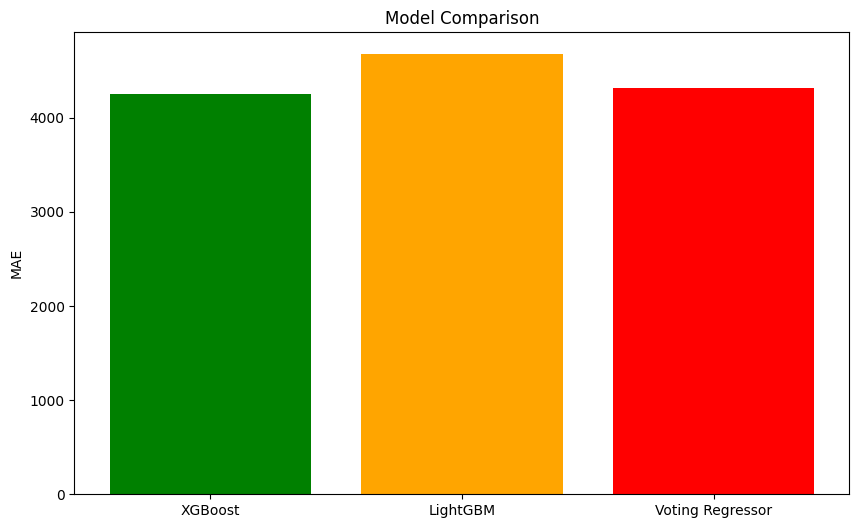

In [101]:
model_names = ['XGBoost', 'LightGBM', 'Voting Regressor']
model_mae = [
    #-rf_study.best_value,
    xgb_study.best_value,
    lgb_study.best_value,
    -voting_scores.mean()
]

plt.figure(figsize=(10, 6))
plt.bar(model_names, model_mae, color=['green', 'orange', 'red'])
plt.ylabel('MAE')
plt.title('Model Comparison')
plt.show()

In [98]:
# 5. Voting Regressor로 예측 수행
voting_regressor.fit(X_train, y_train)
y_pred = voting_regressor.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
print(f"Final Model MAE: {mae:.4f}")

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.010160 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1680
[LightGBM] [Info] Number of data points in the train set: 1440982, number of used features: 12
[LightGBM] [Info] Start training from score 38183.560818
Final Model MAE: 4239.7586


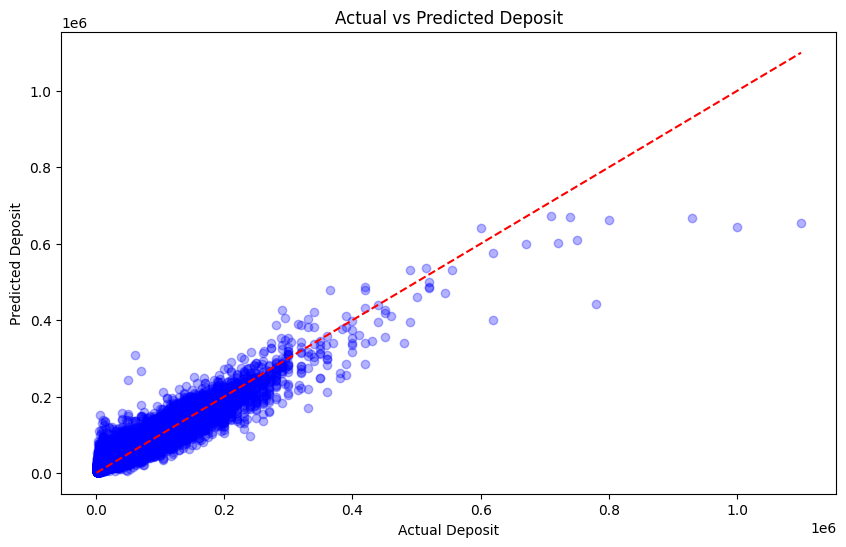

In [100]:
# 6. 결과 분석 및 시각화
# 실제값과 예측값 비교
plt.figure(figsize=(10, 6))
plt.plot(y_test, y_pred, alpha=0.3, color='blue')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--')
plt.xlabel('Actual Deposit')
plt.ylabel('Predicted Deposit')
plt.title('Actual vs Predicted Deposit')
plt.show()

# 실제 test.csv를 활용하여 output.csv 만들기

In [132]:
# test_data와 interest_data 병합
test_data['contract_year_month'] = test_data['contract_year_month'].astype(str)
interest_data['year_month'] = interest_data['year_month'].astype(str)

# left join을 통해 금리 데이터를 병합
test_data = pd.merge(test_data, interest_data, how='left', left_on='contract_year_month', right_on='year_month')

# 중복된 열 제거
test_data.drop(columns=['year_month'], inplace=True)

In [133]:
# 거리 관련
test_data['closest_subway_distance'] = find_closest_distance_kdtree(test_data, subway_data)
test_data['closest_school_distance'] = find_closest_distance_kdtree(test_data, school_data)
test_data['closest_park_distance'] = find_closest_distance_kdtree(test_data, park_data)

In [134]:
# 날짜 관련 피처 생성
test_data['contract_year_month'] = pd.to_datetime(test_data['contract_year_month'], format='%Y%m')
test_data['contract_year'] = test_data['contract_year_month'].dt.year
test_data['contract_month'] = test_data['contract_year_month'].dt.month
test_data['contract_season'] = test_data['contract_year_month'].dt.quarter

In [135]:
# 거리 로그 변환
test_data['log_subway_distance'] = np.log1p(test_data['closest_subway_distance'])
test_data['log_school_distance'] = np.log1p(test_data['closest_school_distance'])
test_data['log_park_distance'] = np.log1p(test_data['closest_park_distance'])

In [137]:
# 위도와 경도를 기반으로 KMeans 클러스터링
coords = test_data[['latitude', 'longitude']]
kmeans = KMeans(n_clusters=3, random_state=42).fit(coords)
test_data['region'] = kmeans.labels_

In [138]:
# 피처 및 타겟 설정
final_test = test_data[['area_m2', 'floor', 'built_year', 'region', 'latitude', 'longitude', 'log_subway_distance', 'log_school_distance', 'log_park_distance', 'contract_year', 'contract_month', 'contract_season']]

In [140]:
voting_regressor_test_pred = voting_regressor.predict(final_test)
sample_submission['deposit'] = voting_regressor_test_pred
sample_submission.to_csv('output.csv', index=False, encoding='utf-8-sig')